In [160]:
import pandas as pd
import numpy as np
import subprocess
import shlex
pd.set_option('display.max_rows', 75)

# Thoughts
Can a contig can still be a contaminant even if it is at lower relative coverage in a control than in the sample?

# Preprocessing

In [119]:
# from sample_name, contigs db, and profile db, generate needed input files
# also take as input, a list of controls sample names

# Script

In [2]:
sample_name = 'AWTP_2_RO2_bulk_3'
#contig_data_file = '/Users/rosekantor/data/awtp2_metagenomics/decontamination/KNLK_58_contigs_basic_info.txt'
taxonomy_file = '/Users/rosekantor/data/awtp2_metagenomics/test_decontamination/KNLK_58_taxonomy_splits.txt'
cov_means_file = '/Users/rosekantor/data/awtp2_metagenomics/test_decontamination/KNLK_58_filt_mean_coverage_Q2Q3_contigs.txt'
cov_stds_file = '/Users/rosekantor/data/awtp2_metagenomics/test_decontamination/KNLK_58_filt_std_coverage_contigs.txt'
detect_file = '/Users/rosekantor/data/awtp2_metagenomics/test_decontamination/KNLK_58_filt_detection_contigs.txt'
out_file = '/Users/rosekantor/data/awtp2_metagenomics/test_decontamination/KNLK_58_contaminants/'

In [3]:
def import_table(anvio_file):
    # import coverage means table
    df = pd.read_csv(anvio_file, sep='\t')
    #df = df.drop(columns = 'contig') #first col is actually the split so remove it since we want contigs (luckily values for all splits in a contig are identical since we specified contig)
    df = df.rename(columns = {'contig': 'split', '__parent__' : 'contig', sample_name : 's'}) 
    #df = df.drop_duplicates() # collapse down to just contig level
    df = df.drop(columns = 'contig')
    df = df.set_index('split')

    return(df)

In [93]:
def score_contigs_cov(cov_means, cov_stds):
    '''Check whether the contig mean coverage is greater in sample than control and
    whether contig normalized standard deviation of coverage is less in sample than in control.
    If both are true, then the contig is not a contaminant.
    If one is false, contig will be in the returned dataframe for further analysis.'''
    
    # calculate relative coverage
    cov_means_norm = cov_means.div(cov_means.sum(axis=0), axis=1)
    # compare each column to s and make a matrix that is boolean control < sample (True is noncontam contig)
    cov_means_norm_lt = cov_means_norm.lt(cov_means_norm.s, axis=0)

    # get coefficient of variance (mean-normalized standard deviation of coverage for each contig)
    cov_stds_norm = cov_stds / cov_means
    cov_stds_norm = cov_stds_norm.replace([np.nan, np.inf], 0)
    # compare each column to s and make a matrix that is boolean control > sample (True is noncontam contig)
    cov_stds_norm_gt = cov_stds_norm.gt(cov_stds_norm.s, axis=0)

    ## combinations of cov_means_norm_lt and cov_stds_norm_gt
    # convert boolean to number and then add, so that:
    # True & True = 2 (noncontam)
    # True & False, False & True = 1 (unknown)
    # False & False = 0 (contam)
    
    iscontam = cov_means_norm_lt*1 + cov_stds_norm_gt*1

    ## special cases of False&True and True&False (both have value of 1)

    ## for any contig where (cov_means_norm.s == 0), change iscontam to 0 for all controls
    s_no_cov = (cov_means_norm.s == 0) * 1
    iscontam = iscontam.subtract(s_no_cov, axis=0) # subtract 1 in cases where sample has no cov.

    # for any contig x control where (cov_means_norm.c == 0), change iscontam to 2 for that control
    c_no_cov = (cov_means_norm==0 * 1)
    iscontam = iscontam.add(c_no_cov) # add 1 in cases where control has no cov.
    
    iscontam = iscontam.drop(columns = 's')
    
    # Remove all contigs where every control comparison yielded a 2 (noncontam)
    cov_contams = iscontam[~((iscontam == 2).all(axis = 'columns'))]

    return(cov_contams)

In [110]:
def score_contigs_detection(detection, cov_contams):
    '''Check detection on suspected contaminant contigs in all controls:
    if detection in control is less than detection in sample - 0.05 then remove from contaminant list
    because coverage is probably due to highly conserved sequence or mismapping, not true presence in sample'''

    # subset detection consider to just possible contaminant contigs
    detect_posscontam = detection[detection.index.isin(cov_contams.index)]

    # make masking df where:
    # True means detection in control is not within 0.05 of the detection in sample, so it is likely to be real
    # False means detection in control is similar to detection in sample, so it is likely to be a contaminant
    detect_posscontam_lt = detect_posscontam.lt(detect_posscontam.s - 0.05, axis=0)
    detect_posscontam_lt = detect_posscontam_lt.drop(columns = 's')
    final_contams = cov_contams[detect_posscontam_lt==False]
    final_contams = final_contams[~((final_contams.isna()).all(axis = 'columns'))]
    
    return(final_contams)

In [145]:
def taxonomy_remove(tax_names, taxonomy_file):
    tax = pd.read_csv(taxonomy_file, sep = '\t', names=['split', 'genus'], index_col=0)
    contam_splits = pd.DataFrame(tax[tax.genus.isin(tax_names)].index)
    return(contam_splits)

In [137]:
# run functions
tax = pd.read_csv(taxonomy_file, sep = '\t', names=['split', 'genus'], index_col=0)

cov_means = import_table(cov_means_file)
cov_stds = import_table(cov_stds_file)
detection = import_table(detect_file)
cov_contams = score_contigs_cov(cov_means, cov_stds)
detect_contams = score_contigs_detection(detection, cov_contams)
#possible_contams.to_csv('~/data/awtp2_metagenomics/KNLK_58_contaminants/contam/KNLK_58_contam_scores.txt', sep='\t')

In [155]:
t = taxonomy_remove(['Lysobacter', 'Asaccharospora'], taxonomy_file)
d = pd.DataFrame(detect_contams.index)
pd.concat([t, d]).drop_duplicates('split')

,split
0,KNLK_58_123223_split_00001
1,KNLK_58_100836_split_00001
2,KNLK_58_481724_split_00001
3,KNLK_58_33625_split_00001
4,KNLK_58_11221_split_00001
...,...
946,KNLK_58_90410_split_00001
947,KNLK_58_91291_split_00001
949,KNLK_58_93484_split_00001
950,KNLK_58_93849_split_00001


In [ ]:
#iscontam = iscontam.add_prefix('score_')
# iscontam = iscontam.replace({0: 'contam', 1: 'unknown', 2: 'noncontam'})

In [127]:
detect_contams.shape#[(detect_contams == 2).any(axis = 'columns')]

(965, 6)

# Test detection

In [44]:
possible_contams_contigs = possible_contams.index.to_list()
len(possible_contams_contigs)

1033

In [116]:
# find contigs that had higher or nearly as high detection in any blank as in sample
control_names = detection.columns.to_list()
control_names.remove('s') # get list of controls to use to subset the detect dataframe
contam_by_detect_df = detect[(detect[control_names].max(axis=1) + 0.05) >= detect.s]
detect_contam_contigs = contam_by_detect_df.index.to_list()
len(detect_contam_contigs)

970

In [123]:
len(set(possible_contams_contigs) - set(detect_contam_contigs)) # = 68
detect_not_cov = list(set(detect_contam_contigs) - set(cov_contams.index)) # = 5

#not_detect = list(set(possible_contams_contigs) - set(detect_contam_contigs))
#not_detect_df = detect[detect.index.isin(not_detect)]

In [125]:
tax[tax.index.isin(detect_not_cov)]

,genus
split,
KNLK_58_91778_split_00001,Mycobacterium
KNLK_58_51681_split_00001,NaN
KNLK_58_175146_split_00001,T5virus
KNLK_58_387596_split_00001,Unknown_Caudovirales
KNLK_58_433385_split_00001,Unknown_Verrucomicrobia


In [114]:
1033 - 68

965

In [50]:
'KNLK_58_10080_split_00001' in not_detect

True

In [321]:
# what contigs were reported by the detection method but not  by the coverage method
detect_not_cov = list(set(detect_contam_contigs) - set(possible_contams_contigs))
display(cov_means[cov_means.index.isin(detect_not_cov)].merge(tax, how='left', on='split'))
display(cov_stds[cov_stds.index.isin(detect_not_cov)])
display(detect[detect.index.isin(detect_not_cov)])
display(iscontam[iscontam.index.isin(detect_not_cov)])

,s,neg_ex_1,neg_field_1,neg_field_2,neg_field_bf,pos_ex_1,pos_ex_2,genus
split,,,,,,,,
KNLK_58_175146_split_00001,161.747617,0.0,7.593578,0.0,12.660813,0.242348,0.0,T5virus
KNLK_58_387596_split_00001,82.869547,0.0,4.001223,0.0,8.252752,0.234815,0.0,Unknown_Caudovirales
KNLK_58_433385_split_00001,62.796555,0.0,4.543068,0.0,6.739130,0.428220,0.0,Unknown_Verrucomicrobia
KNLK_58_51681_split_00001,18.073084,0.0,5.103387,0.0,8.178253,0.000000,0.0,NaN
KNLK_58_91778_split_00001,79.135472,0.0,6.890374,0.0,6.396613,0.229947,0.0,Mycobacterium


,s,neg_ex_1,neg_field_1,neg_field_2,neg_field_bf,pos_ex_1,pos_ex_2
split,,,,,,,
KNLK_58_175146_split_00001,54.527095,0.378832,4.048214,0.190373,7.468798,1.501851,0.498211
KNLK_58_387596_split_00001,21.544431,0.000000,3.218208,0.408411,6.105507,1.021115,0.172214
KNLK_58_433385_split_00001,32.034552,0.375200,3.448368,0.408702,3.608583,1.393819,0.000000
KNLK_58_51681_split_00001,10.508541,0.000000,3.019266,0.000000,4.913403,0.000000,0.000000
KNLK_58_91778_split_00001,28.199513,0.000000,3.917468,0.000000,5.425999,1.419072,0.000000


,s,neg_ex_1,neg_field_1,neg_field_2,neg_field_bf,pos_ex_1,pos_ex_2
split,,,,,,,
KNLK_58_175146_split_00001,0.997489,0.142857,0.954306,0.037660,0.974140,0.371077,0.189305
KNLK_58_387596_split_00001,0.998368,0.000000,0.917805,0.092392,0.990006,0.367326,0.030594
KNLK_58_433385_split_00001,0.993435,0.106689,0.901929,0.093558,0.951990,0.427165,0.000000
KNLK_58_51681_split_00001,0.987489,0.000000,0.912422,0.000000,0.951743,0.000000,0.000000
KNLK_58_91778_split_00001,0.996878,0.000000,0.978145,0.000000,0.998216,0.364853,0.000000


,score_neg_ex_1,score_neg_field_1,score_neg_field_2,score_neg_field_bf,score_pos_ex_1,score_pos_ex_2
split,,,,,,
KNLK_58_175146_split_00001,noncontam,noncontam,noncontam,noncontam,noncontam,noncontam
KNLK_58_387596_split_00001,noncontam,noncontam,noncontam,noncontam,noncontam,noncontam
KNLK_58_433385_split_00001,noncontam,noncontam,noncontam,noncontam,noncontam,noncontam
KNLK_58_51681_split_00001,noncontam,noncontam,noncontam,noncontam,noncontam,noncontam
KNLK_58_91778_split_00001,noncontam,noncontam,noncontam,noncontam,noncontam,noncontam


,genus
split,
KNLK_58_91778_split_00001,Mycobacterium
KNLK_58_51681_split_00001,NaN
KNLK_58_175146_split_00001,T5virus
KNLK_58_387596_split_00001,Unknown_Caudovirales
KNLK_58_433385_split_00001,Unknown_Verrucomicrobia


In [341]:
# which contigs were reported as possible contams by the coverage method but not by detection? (suggesting they may not actually be contaminants)
display(cov_means[cov_means.index.isin(not_detect)].merge(tax, how='left', on='split').merge(cov_stds, how='left', on='split').round(2))
#display(possible_contams[possible_contams.index.isin(not_detect)])
display(354.65/220.28)
display(146.02/171.33)

,s_x,neg_ex_1_x,neg_field_1_x,neg_field_2_x,neg_field_bf_x,pos_ex_1_x,pos_ex_2_x,genus,s_y,neg_ex_1_y,neg_field_1_y,neg_field_2_y,neg_field_bf_y,pos_ex_1_y,pos_ex_2_y
split,,,,,,,,,,,,,,,
KNLK_58_10037_split_00001,48.84,0.00,0.02,0.00,2.08,0.41,0.00,Unknown_Betaproteobacteria,79.15,0.00,0.75,0.00,3.03,1.40,0.65
KNLK_58_10080_split_00001,1.97,0.00,1.57,0.00,3.66,0.01,0.01,Unknown_Alphaproteobacteria,1.26,0.00,4.96,0.00,13.14,0.44,0.44
KNLK_58_10152_split_00001,14.14,4.88,51.37,0.13,88.73,2.20,0.00,Unknown_Alphaproteobacteria,6.53,6.01,26.03,1.60,40.38,2.16,0.64
KNLK_58_105463_split_00001,2.30,0.00,1.62,0.00,2.12,0.00,0.00,Rickettsia,3.54,0.00,15.27,0.00,29.86,0.00,0.00
KNLK_58_113171_split_00001,8.95,0.00,4.97,0.00,9.25,1.72,0.05,Nitrosomonas,5.81,0.37,4.74,0.00,7.00,1.77,0.56
KNLK_58_117233_split_00001,2.20,0.00,3.93,0.00,7.67,0.00,0.00,Unknown_Betaproteobacteria,0.93,0.00,3.33,0.00,8.18,0.00,0.00
KNLK_58_133487_split_00001,1.22,0.17,0.48,0.00,1.81,0.14,0.00,Mycobacterium,2.25,3.54,1.22,0.00,4.10,0.80,0.00
KNLK_58_137858_split_00001,1.21,0.00,0.95,0.00,4.79,0.00,0.00,Aquabacterium,0.74,0.00,1.56,0.00,3.80,0.00,0.00
KNLK_58_138203_split_00001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Angomonas,1.18,0.00,0.00,0.00,0.00,0.00,0.00


1.6099963682585798

0.8522733905328898

In [355]:
collection_nodetect = pd.DataFrame(not_detect, columns=['split'])
collection_nodetect['bin'] = 'not_detect'
collection_nodetect_file = '/Users/rosekantor/data/awtp2_metagenomics/test_decontamination/contam_no_detect_collection.txt'
collection_nodetect.to_csv(collection_nodetect_file, header=False, index=False, sep='\t')

In [314]:
# special case: KNLK_58_10152_split_00001 has med-high pretty even coverage in samples and some controls.
# Coverage ends right on either side of the genes, doesn't extend to the edges of the contig
# detection is 1 in sample and next highest control is 0.87 (so it didn't pass the "detection" threshold)
# in Anvio, this contig clusters in a bin that I wasn't sure about- maybe contaminant, maybe not
# This contig has a transposase! It is possibly not a contaminant then... just similar to something in contaminants?
not_detect_df[not_detect_df.index == 'KNLK_58_10152_split_00001']
tax[tax.index == 'KNLK_58_10152_split_00001']


,genus
split,
KNLK_58_10152_split_00001,Unknown_Alphaproteobacteria


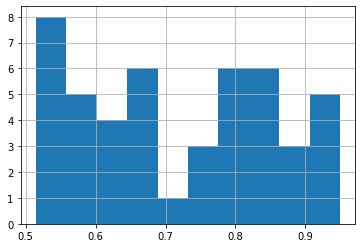

In [250]:
# Is 0.05 a good threshold? (check distribution- is there a clear cut-off?)
max_cont_detect = not_detect_df[control_names].max(axis=1) #.hist()
max_cont_detect_50 = max_cont_detect[max_cont_detect>0.5]#
max_cont_detect_50.hist()

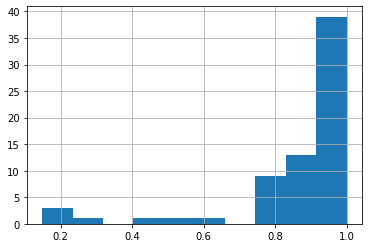

In [254]:
s_detect = not_detect_df['s']
s_detect.hist()#[s_detect>0.5].hist()

# Check that contigs of known contam taxonomy are removed
Lysobacter and Asaccharospora

In [316]:
all_contigs = tax.index
lysobacter_contigs = tax[tax.genus=='Lysobacter'].index
asaccharospora_contigs = tax[tax.genus=='Asaccharospora'].index

In [278]:
# which Lysobacter contigs were missed by the decontamination? 22. All of them had 0x coverage in controls.
missed_lysobacter = list(set(lysobacter_contigs) - set(possible_contams_contigs))
cov_means[cov_means.index.isin(missed_lysobacter)].sort_values('s')

,s,neg_ex_1,neg_field_1,neg_field_2,neg_field_bf,pos_ex_1,pos_ex_2
split,,,,,,,
KNLK_58_27354_split_00001,1.452609,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_420504_split_00001,2.112500,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_352364_split_00001,2.722191,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_506679_split_00001,2.806985,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_106197_split_00001,2.893726,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_311382_split_00001,2.978178,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_445879_split_00001,3.023963,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_110577_split_00001,3.162200,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_318329_split_00001,3.281389,0.0,0.0,0.0,0.0,0.0,0.0


In [297]:
# which Asaccharospora contigs were missed by the decontamination? None!
len(set(asaccharospora_contigs) - set(possible_contams_contigs))

0

In [284]:
# there are 4 contigs that have 0 coverage in all controls and the sample (after filtering) - toss these?
cov_means[(cov_means == 0).all(axis = 'columns')]

,s,neg_ex_1,neg_field_1,neg_field_2,neg_field_bf,pos_ex_1,pos_ex_2
split,,,,,,,
KNLK_58_138203_split_00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_171115_split_00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_210574_split_00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_47619_split_00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [291]:
# there are 106339 contigs that have 0 coverage in all controls (after filtering)
cov_means[(cov_means[control_names] == 0).all(axis = 'columns')]

,neg_ex_1,neg_field_1,neg_field_2,neg_field_bf,pos_ex_1,pos_ex_2
split,,,,,,
KNLK_58_100007_split_00001,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_100008_split_00001,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_100009_split_00001,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_100013_split_00001,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_100031_split_00001,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
KNLK_58_99985_split_00001,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_99986_split_00001,0.0,0.0,0.0,0.0,0.0,0.0
KNLK_58_99988_split_00001,0.0,0.0,0.0,0.0,0.0,0.0


# Old

In [140]:
collection = pd.DataFrame(possible_contams.index)
collection['bin'] = 'contam'
collection

,split,bin
0,KNLK_58_100189_split_00001,contam
1,KNLK_58_100346_split_00001,contam
2,KNLK_58_10037_split_00001,contam
3,KNLK_58_100456_split_00001,contam
4,KNLK_58_100490_split_00001,contam
...,...,...
1673,KNLK_58_99127_split_00001,contam
1674,KNLK_58_99127_split_00002,contam
1675,KNLK_58_99370_split_00001,contam
1676,KNLK_58_99632_split_00001,contam


In [123]:
# trying to get contig column for testing
t = possible_contams.reset_index()
t['contig'] = t['split'].str.extract(r'(.+)_split_\d+')
t= t.drop(columns='split')
t = t.drop_duplicates()
t = t.set_index('contig')

iscontamm = t.reset_index().melt(id_vars=['contig'],
                          var_name='control',
                          value_name='contamination')
p = pd.DataFrame(iscontamm[iscontamm.contamination!='noncontam'].contig.unique(), columns=['contigs'])
p

,contigs
0,KNLK_58_100346
1,KNLK_58_100456
2,KNLK_58_100490
3,KNLK_58_100836
4,KNLK_58_100999
...,...
1613,KNLK_58_87401
1614,KNLK_58_90394
1615,KNLK_58_92561
1616,KNLK_58_93295


In [180]:
# questions
# what fraction of negative controls is from positive control contam
# what should rule be: 1) if any control says the contig is a contam, then it is contam (what about cross-contam of samples into just one control?)
#                      2) if any control says contig is noncontam, then it is noncontam (some controls won't have enough info)

In [120]:
## import contig table
# contig_data = pd.read_csv(contig_data_file, sep='\t')
# contig_data = contig_data.set_index('contig')

In [212]:
possible_contams = pd.DataFrame(iscontamm[iscontamm.contamination!=2].contig.unique(), columns=['contigs'])
possible_contams['bin']='contam'

In [213]:
possible_contams.head()

,contigs,bin
0,KNLK_23_314861,contam
1,KNLK_23_63001,contam
2,KNLK_23_223930,contam
3,KNLK_23_279903,contam
4,KNLK_23_237933,contam


In [214]:
possible_contams.to_csv(out_file, header=False, index=False, sep='\t')

In [158]:
profileDB = '~/data/awtp2_metagenomics/test_decontamination/KNLK_58_merged_profiles_filtered/PROFILE.db'
contigsDB = '~/data/awtp2_metagenomics/test_decontamination/KNLK_58_contigs.db'
name = 'AWTP_2_RO2_bulk_3'
mcov_cmd = f'anvi-export-table --table mean_coverage_Q2Q3_splits {profileDB} -o {name}_coverage_Q2Q3_splits.txt'
scov_cmd = f'anvi-export-table --table std_coverage_splits {profileDB} -o {name}_std_coverage_splits.txt'
dcov_cmd = f'anvi-export-table -t detection_splits {profileDB} -o {name}_detection_splits.txt'
tax_cmd = f'anvi-export-splits-taxonomy -c {contigsDB} -o {name}_taxonomy_splits.txt'
all_cmd = [mcov_cmd, scov_cmd, dcov_cmd, tax_cmd]

In [163]:
#for i in all_cmd:
#    subprocess.run(shlex.split(i))
    

FileNotFoundError: [Errno 2] No such file or directory: 'anvi-export-table': 'anvi-export-table'